In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


Final Introduction: In NYC there are traffic cameras that have public APIs and I thought it would be cool if those could be used to help find lost dogs. The first step of that process is making a neural net that can detect when an image contains a dog. 

For this I will be making an CNN using a subset of the pictures of dogs data set from the Kaggle for week 5, that I converted to be 256x256, that we didn't do and for the random images that don't contain dogs I will be using the random pictures that we turned into Monet paintings from the other homework 5 kaggle.

In [3]:
dogDir = "dog_data"
randomDir = "photo_jpg"

dogPaths = os.listdir(dogDir)
randPaths = os.listdir(randomDir)

for i in range(len(dogPaths)):
    dogPaths[i] = dogDir+"/"+dogPaths[i]

for i in range(len(randPaths)):
    randPaths[i] = randomDir+"/"+randPaths[i]

print("Number of dog pictures: ",len(dogPaths))
print("Number of random pictures: ",len(randPaths))

Number of dog pictures:  8782
Number of random pictures:  7038


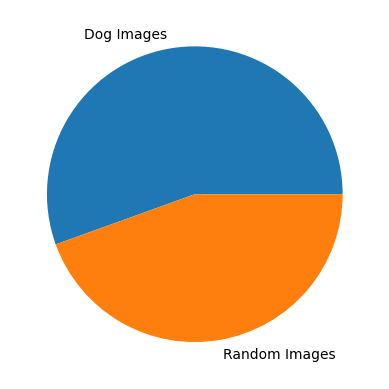

In [5]:
y = np.array([len(dogPaths), len(randPaths)])
mylabels = ["Dog Images", "Random Images"]

plt.pie(y, labels = mylabels)
plt.show() 

Data Preprocessing:
The only data preprocessing I had to do was load the file paths from the directory into a dataframe so that the image generator could pull from dataframe later and get images from multiple directories and then also add the labels as I added them to the DF (1 for dog and 0 for not dog)

In [19]:
#combine all of the data with labels into one pandas DF 
#1=dog 0=random

dogLabels = np.ones(len(dogPaths))
randLabels = np.zeros(len(randPaths))

#combine lists
combinePaths = dogPaths + randPaths
combineLabels = np.concatenate((dogLabels, randLabels))

#make df from combined data
data = pd.DataFrame()
data["paths"] = combinePaths
data["labels"] = combineLabels

#check that the labels line up
print(data.head())
print(data.tail())

                       paths  labels
0  dog_data/003EXDTCRL8P.jpg     1.0
1  dog_data/009NK4DESSV2.jpg     1.0
2  dog_data/00F70KTJDXLD.jpg     1.0
3  dog_data/00REQC3MRWQJ.jpg     1.0
4  dog_data/010PTA2BL3TI.jpg     1.0
                          paths  labels
15815  photo_jpg/ffd71fce61.jpg     0.0
15816  photo_jpg/ffe1af8ca0.jpg     0.0
15817  photo_jpg/fff5c33050.jpg     0.0
15818  photo_jpg/fffaaaae65.jpg     0.0
15819  photo_jpg/fffc0836d7.jpg     0.0


In [28]:
#now we ned randomized train and test splits from the data
X_train, X_test, y_train, y_test = train_test_split(data["paths"], 
                                                    data["labels"], 
                                                    test_size=0.2, 
                                                    random_state=42)

trainDF = pd.DataFrame()
trainDF["X"] = X_train
trainDF["y"] = y_train.astype(str)
print(trainDF.head())

testDF = pd.DataFrame()
testDF["X"] = X_test
testDF["y"] = y_test.astype(str)
print(testDF.head())




                               X    y
12220   photo_jpg/79dd5cd9b8.jpg  0.0
5955   dog_data/OI1Y5VI5RT4P.jpg  1.0
13273   photo_jpg/a25eb81721.jpg  0.0
3784   dog_data/FS4TD2DGOH25.jpg  1.0
4467   dog_data/IK19PTZ0V0TE.jpg  1.0
                              X    y
8271  dog_data/XXNQ1Z321YSW.jpg  1.0
169   dog_data/0QGWM18794H1.jpg  1.0
6595  dog_data/R1XZ33YG3146.jpg  1.0
6558  dog_data/QW6F8905FFGP.jpg  1.0
7309  dog_data/TYAPH05FWUIH.jpg  1.0


In [29]:
#create the image generators to input the image data into the CNN
trainImageData = ImageDataGenerator().flow_from_dataframe(
    dataframe=trainDF,
    x_col='X',
    y_col='y',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

testImageData = ImageDataGenerator().flow_from_dataframe(
    dataframe=testDF,
    x_col='X',
    y_col='y',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

Found 12656 validated image filenames belonging to 2 classes.
Found 3164 validated image filenames belonging to 2 classes.


In [31]:
#create the model
filterFactor = 64

model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(filterFactor, (3,3), activation = "relu", input_shape=(256,256,3)),
    MaxPooling2D(2,2),
    Conv2D(filterFactor*2, (3,3), activation = "relu", input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(filterFactor*4, (3,3), activation = "relu", input_shape=(64,64,3)),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation = "sigmoid") #needed to flatten everything to a final answer
    
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 921600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    58,982,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,353,345 (226.42 MB)

 Trainable params: 59,353,345 (226.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#compile the model using optimizer and loss functions discussed in class
model.compile(optimizer='Adagrad', loss='BinaryCrossentropy', metrics=['accuracy'])

In [34]:
hist = model.fit(trainImageData, epochs=5, validation_data=testImageData)

Epoch 1/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.6575 - loss: 0.5949 - val_accuracy: 0.9036 - val_loss: 0.2911
Epoch 2/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.8419 - loss: 0.3665 - val_accuracy: 0.9257 - val_loss: 0.2343
Epoch 3/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.8865 - loss: 0.3123 - val_accuracy: 0.9412 - val_loss: 0.1885
Epoch 4/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.9018 - loss: 0.2791 - val_accuracy: 0.9507 - val_loss: 0.1482
Epoch 5/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.9225 - loss: 0.2401 - val_accuracy: 0.9608 - val_loss: 0.1354


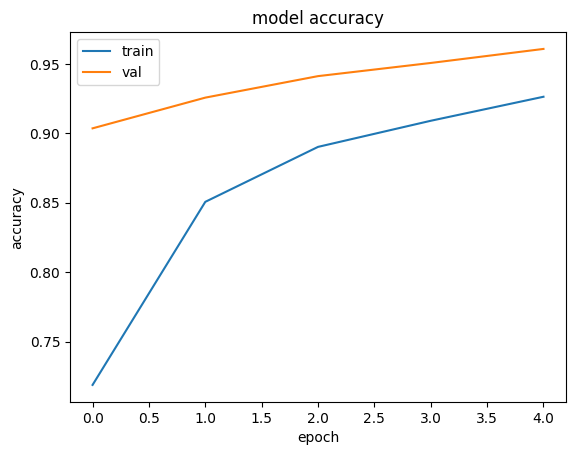

In [35]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Conclusion:
With a relatively quick run I was able to make a CNN that could identify dogs 96% of the time against the test data set. This shows the power of these models and with more time and resources to make it breed specific I feel like it would be very possible to have a model that could help track specific dog types on open camera feeds and potentially help find lost dogs.